In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression

In [9]:
train_data = pd.read_csv('train_data.csv', usecols=['stemmed_tokens', 'type'])                            # Reads train_data csv file created earlier to DataFrame
validation_data = pd.read_csv('validation_data.csv', usecols=['stemmed_tokens', 'type'])                  # Reads validation_data csv file created earlier to DataFrame
test_data = pd.read_csv('test_data.csv', usecols=['stemmed_tokens', 'type'])
# Extract content and labels
X_train = train_data['stemmed_tokens']
y_train = train_data['type']
X_val = validation_data['stemmed_tokens']
y_val = validation_data['type']
x_test = test_data['stemmed_tokens']
y_test = test_data['type']

In [4]:
# Convert text to TF-IDF features (tager sådan en halv time tror jeg )
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # Use unigrams & bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(x_test)

In [ ]:
# Train logistic regression model 
model = LogisticRegression(max_iter=1500, class_weight='balanced') 
model.fit(X_train_tfidf, y_train)

# Predictions
y_val_pred = model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, pos_label=1)
report = classification_report(y_val, y_val_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8683
F1 Score: 0.8631
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87     39216
           1       0.86      0.87      0.86     35770

    accuracy                           0.87     74986
   macro avg       0.87      0.87      0.87     74986
weighted avg       0.87      0.87      0.87     74986



## HalvingRandomSearchCV for Optimizing Logistic Regression Performance

With random reproducibility

In [ ]:

"""
This code block performs hyperparameter tuning for a Logistic Regression model using Halving Random Search Cross-Validation. It prepares the data, fits the model, evaluates its performance, and displays the results.

1. `from sklearn.experimental import enable_halving_search_cv`:
   - This line imports the necessary module to enable the use of Halving Random Search Cross-Validation, which is a more efficient method for hyperparameter tuning.

2. `from sklearn.model_selection import HalvingRandomSearchCV`:
   - This line imports the `HalvingRandomSearchCV` class, which is used for hyperparameter optimization by progressively narrowing down the search space.

3. `from sklearn.linear_model import LogisticRegression`:
   - This line imports the `LogisticRegression` class from the `sklearn.linear_model` module, which will be used as the estimator for the model.

4. `import pandas as pd` and `import numpy as np`:
   - These lines import the pandas and NumPy libraries, which are commonly used for data manipulation and numerical operations.

5. `y_train_dense = y_train.toarray() if hasattr(y_train, "toarray") else y_train`:
   - This line ensures that the target variable `y_train` is in a dense format. If `y_train` has a `toarray` method (indicating it is a sparse matrix), it converts it to a dense array; otherwise, it leaves it unchanged.

6. `X_train_dense = X_train_tfidf.toarray() if hasattr(X_train_tfidf, "toarray") else X_train_tfidf`:
   - This line ensures that the feature matrix `X_train_tfidf` is also in a dense format, similar to the previous step for `y_train`.

7. `param_grid = [...]`:
   - This block defines the parameter grid for hyperparameter tuning. It includes:
     - `penalty`: Types of regularization ('l2' or 'none').
     - `C`: Inverse of regularization strength, specified as a logarithmic space from \(10^{-4}\) to \(10^{4}\).
     - `solver`: Optimization algorithms to use ('liblinear', 'saga', 'lbfgs').
     - `max_iter`: Maximum number of iterations for the optimization algorithm (100, 500, 1000, 5000).

8. `search = HalvingRandomSearchCV(...)`:
   - This line instantiates the `HalvingRandomSearchCV` object with the following parameters:
     - `estimator`: The Logistic Regression model with balanced class weights.
     - `param_distributions`: The parameter grid defined earlier.
     - `cv`: Number of cross-validation folds (7).
     - `verbose`: Level of verbosity for logging (1).
     - `n_jobs`: Number of jobs to run in parallel (-1 means using all processors).

9. `search.fit(X_train_dense, y_train_dense)`:
   - This line fits the Halving Random Search model to the training data, performing hyperparameter tuning based on the specified parameter grid.

10. `y_val_pred = search.predict(X_train_dense)`:
    - This line uses the best model found during the search to make predictions on the training data (note: typically, predictions should be made on a validation set).

11. `accuracy = accuracy_score(y_train_dense, y_val_pred)`:
    - This line calculates the accuracy of the model's predictions by comparing the predicted labels with the true labels.

12. `f1 = f1_score(y_train_dense, y_val_pred, average='weighted')`:
    - This line calculates the weighted F1 score, which considers the balance of classes in the dataset.

13. `report = classification_report(y_train_dense, y_val_pred)`:
    - This line generates a detailed classification report that includes precision, recall, F1 score, and support for each class.
"""

from sklearn.experimental import enable_halving_search_cv  # Import this first
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np


# Ensure y_train is dense
y_train_dense = y_train.toarray() if hasattr(y_train, "toarray") else y_train

# Ensure X_train_tfidf is dense
X_train_dense = X_train_tfidf.toarray() if hasattr(X_train_tfidf, "toarray") else X_train_tfidf

# Example parameter grid
param_grid = [
    {'penalty':['l2', 'none'],
    'C': np.logspace(-4,4,10),
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 500, 1000, 5000]
}
]
# Instantiate HalvingRandomSearchCV
search = HalvingRandomSearchCV(
    estimator=LogisticRegression(class_weight='balanced'),
    param_distributions=param_grid,
    cv=7,
    verbose=1,
    n_jobs=-1
)

# Fit the model
search.fit(X_train_dense, y_train_dense)


# Best Model Evaluation
y_val_pred = search.predict(X_train_dense)  # Directly using search to predict

accuracy = accuracy_score(y_train_dense, y_val_pred)
f1 = f1_score(y_train_dense, y_val_pred, average='weighted')
report = classification_report(y_train_dense, y_val_pred)

# Print best parameters and evaluation metrics
print("Best Parameters:", search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)

# Convert search results to DataFrame
results_df = pd.DataFrame(search.cv_results_)

# Select relevant columns
columns_to_display = ["param_C", "param_max_iter", "mean_test_score", "rank_test_score", "iter"]
results_df = results_df[columns_to_display]

# Sort by best rank
results_df = results_df.sort_values(by="rank_test_score")

# Print top results

print(results_df.head())

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 10
min_resources_: 28
max_resources_: 599891
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 28
Fitting 7 folds for each of 240 candidates, totalling 1680 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 240 is smaller than n_iter=21424. Running 240 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-pack

----------
iter: 1
n_candidates: 80
n_resources: 84
Fitting 7 folds for each of 80 candidates, totalling 560 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max

----------
iter: 2
n_candidates: 27
n_resources: 252
Fitting 7 folds for each of 27 candidates, totalling 189 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5952381  0.48809524 0.5952381         nan        nan        nan
 0.5952381  0.44047619 0.5952381         nan        nan        nan
 0.5952381  0.41666667 0.5952381         nan        nan        nan
 0.5952381  0.51190476 0.5952381         nan        nan        nan
 0.5952381  0.36904762 0.5952381         nan        nan        nan
 0.5952381  0.44047619 0.5952381         nan        nan        nan
 0.5952381  0.70238095 0.5952381         nan        nan        nan
 0.5952381  0.41666667 0.5952381         nan        nan        nan
 0.5952381  0.69047619 0.76190476        nan        nan        nan


----------
iter: 3
n_candidates: 9
n_resources: 756
Fitting 7 folds for each of 9 candidates, totalling 63 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5952381  0.48809524 0.5952381         nan        nan        nan
 0.5952381  0.44047619 0.5952381         nan        nan        nan
 0.5952381  0.41666667 0.5952381         nan        nan        nan
 0.5952381  0.51190476 0.5952381         nan        nan        nan
 0.5952381  0.36904762 0.5952381         nan        nan        nan
 0.5952381  0.44047619 0.5952381         nan        nan        nan
 0.5952381  0.70238095

----------
iter: 4
n_candidates: 3
n_resources: 2268
Fitting 7 folds for each of 3 candidates, totalling 21 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5952381  0.48809524 0.5952381         nan        nan        nan
 0.5952381  0.44047619 0.5952381         nan        nan        nan
 0.5952381  0.41666667 0.5952381         nan        nan        nan
 0.5952381  0.51190476 0.5952381         nan        nan        nan
 0.5952381  0.36904762 0.5952381         nan        nan        nan
 0.5952381  0.44047619 0.5952381         nan        nan        nan
 0.5952381  0.70238095 0.5952381         nan        nan        nan
 0.5952381  0.41666667 0.5952381         nan        nan        nan
 0.5952381  0.69047619 0.76190476        nan        nan        nan
 0.5952381  0.67857143 0.76190476        nan        nan        nan
 0.595

Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 500, 'C': np.float64(21.54434690031882)}
Accuracy: 0.8812
F1 Score: 0.8812
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89    315661
           1       0.87      0.88      0.88    284230

    accuracy                           0.88    599891
   macro avg       0.88      0.88      0.88    599891
weighted avg       0.88      0.88      0.88    599891

       param_C  param_max_iter  mean_test_score  rank_test_score  iter
358  21.544347            1000         0.780257                1     4
357  21.544347             500         0.780257                1     4
356  21.544347             100         0.779374                3     4
347  21.544347            5000         0.762609                4     3
350  21.544347             500         0.762609                4     3


In [10]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

train_data = pd.read_csv('train_data.csv', usecols=['stemmed_tokens', 'type'])
validation_data = pd.read_csv('validation_data.csv', usecols=['stemmed_tokens', 'type'])
test_data = pd.read_csv('test_data.csv', usecols=['stemmed_tokens', 'type'])

X_train = train_data['stemmed_tokens']
y_train = train_data['type']
X_val = validation_data['stemmed_tokens']
y_val = validation_data['type']
X_test = test_data['stemmed_tokens']  # Fixed typo (was 'x_test')
y_test = test_data['type']

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)  # Fixed typo

X_train_dense = X_train_tfidf.toarray() if hasattr(X_train_tfidf, "toarray") else X_train_tfidf
X_val_dense = X_val_tfidf.toarray() if hasattr(X_val_tfidf, "toarray") else X_val_tfidf
X_test_dense = X_test_tfidf.toarray() if hasattr(X_test_tfidf, "toarray") else X_test_tfidf

param_grid = {
    'penalty': ['l2', 'none'],
    'C': np.logspace(-4, 4, 10),  # Directly use these values
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000, 5000]
}

search = HalvingRandomSearchCV(
    estimator=LogisticRegression(class_weight='balanced'),
    param_distributions=param_grid,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_dense, y_train)

y_val_pred = search.predict(X_val_dense)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Best Parameters:", search.best_params_)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

y_test_pred = search.predict(X_test_dense)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 10
min_resources_: 20
max_resources_: 599891
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 160
n_resources: 20
Fitting 5 folds for each of 160 candidates, totalling 800 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 160 is smaller than n_iter=29994. Running 160 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-pack

----------
iter: 1
n_candidates: 54
n_resources: 60
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max

----------
iter: 2
n_candidates: 18
n_resources: 180
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.45              nan        nan 0.56666667 0.55
        nan        nan 0.56666667 0.58333333        nan        nan
 0.56666667 0.55              nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.51666667        nan        nan 0.56666667 0.51666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.68333333        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.61666667 0.61666667
        nan        nan 0.61666667 0.61666667        nan        nan
 0.61666667 0.61666667        nan        nan 0.61666667 0

----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.45              nan        nan 0.56666667 0.55
        nan        nan 0.56666667 0.58333333        nan        nan
 0.56666667 0.55              nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.51666667        nan        nan 0.56666667 0.51666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.68333333        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.61666667 0.61666667
        nan        nan 0.61666667 0.61666667        nan        nan
 0.61666667 0.61666667        nan        nan 0.61666667 0

----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.45              nan        nan 0.56666667 0.55
        nan        nan 0.56666667 0.58333333        nan        nan
 0.56666667 0.55              nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.51666667        nan        nan 0.56666667 0.51666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.68333333        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.61666667 0.61666667
        nan        nan 0.61666667 0.61666667        nan        nan
 0.61666667 0.61666667        nan        nan 0.61666667 0

Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'C': np.float64(2.782559402207126)}
Validation Accuracy: 0.8713
Validation F1 Score: 0.8714
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     39216
           1       0.86      0.87      0.87     35770

    accuracy                           0.87     74986
   macro avg       0.87      0.87      0.87     74986
weighted avg       0.87      0.87      0.87     74986

Test Accuracy: 0.8710
Test F1 Score: 0.8711


# Confusion Matrix

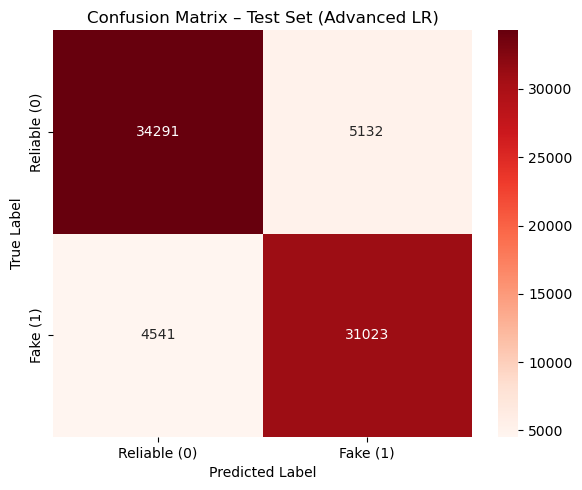

Confusion Matrix:
 [[34291  5132]
 [ 4541 31023]]


In [8]:
"""
This code block visualizes the confusion matrix for the predictions made on the test dataset and prints the confusion matrix values. It uses Matplotlib and Seaborn for plotting.
1. `cm = confusion_matrix(y_test, y_test_pred)`:
   - This line computes the confusion matrix using the true labels (`y_test`) and the predicted labels (`y_test_pred`). 
   - The confusion matrix summarizes the performance of the classification model by showing the counts of true positive, true negative, false positive, and false negative predictions.

2. `plt.figure(figsize=(6, 5))`:
   - This line creates a new figure for the plot with a specified size of 6 inches by 5 inches.

3. `sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ...)`:
   - This line creates a heatmap visualization of the confusion matrix using Seaborn's `heatmap` function. 
   - The parameters used are:
     - `cm`: The confusion matrix data.
     - `annot=True`: Annotates the heatmap with the numeric values of the confusion matrix.
     - `fmt='d'`: Formats the annotations as integers.
     - `cmap='Reds'`: Sets the color map to shades of red.

4. `xticklabels=['Reliable (0)', 'Fake (1)']` and `yticklabels=['Reliable (0)', 'Fake (1)']`:
   - These parameters set the labels for the x-axis and y-axis of the heatmap, indicating the predicted and true labels, respectively.

5. `plt.xlabel("Predicted Label")`:
   - This line sets the label for the x-axis of the plot.

6. `plt.ylabel("True Label")`:
   - This line sets the label for the y-axis of the plot.

7. `plt.title("Confusion Matrix – Test Set (Advanced LR)")`:
    - This line sets the title of the plot, indicating that it represents the confusion matrix for the test set using an advanced logistic regression model.

8. `plt.tight_layout()`:
    - This line adjusts the padding of the plot to ensure that all elements fit within the figure area without overlapping.

9. `plt.show()`:
    - This line displays the plot to the user.

10. `print("Confusion Matrix:\n", cm)`:
    - This line prints the confusion matrix values to the console, providing a numerical representation of the model's performance on the test dataset.

Overall, this code block effectively visualizes the confusion matrix for the test set predictions, providing insights into the classification performance of the model, and prints the confusion matrix for further analysis.
"""

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Reliable (0)', 'Fake (1)'],
            yticklabels=['Reliable (0)', 'Fake (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set (Advanced LR)")
plt.tight_layout()
plt.show()
print("Confusion Matrix:\n", cm)


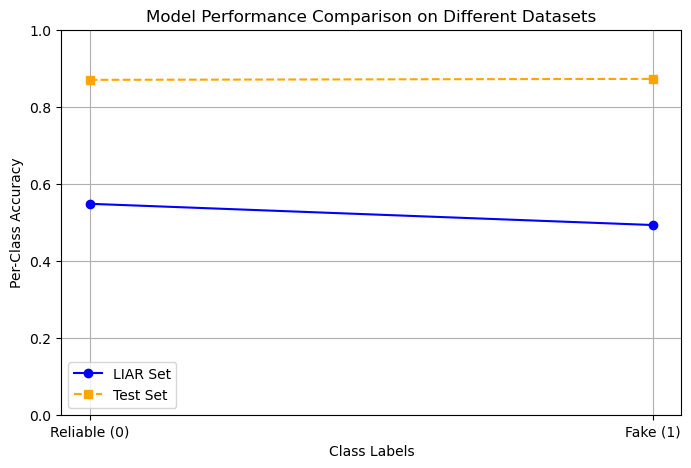

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Class Labels
classes = ["Reliable (0)", "Fake (1)"]

# Confusion Matrices
cm_A = np.array([[246, 203], [173, 168]])  # LIAR Set
cm_B = np.array([[34291, 5132], [4541, 31023]])  # Test Set

# Calculate per-class accuracy
acc_A = [cm_A[0, 0] / (cm_A[0, 0] + cm_A[0, 1]),  # Reliable (0)
         cm_A[1, 1] / (cm_A[1, 1] + cm_A[1, 0])]  # Fake (1)

acc_B = [cm_B[0, 0] / (cm_B[0, 0] + cm_B[0, 1]),  # Reliable (0)
         cm_B[1, 1] / (cm_B[1, 1] + cm_B[1, 0])]  # Fake (1)

# Plot the comparison
plt.figure(figsize=(8, 5))
plt.plot(classes, acc_A, marker='o', linestyle='-', color='blue', label="LIAR Set")
plt.plot(classes, acc_B, marker='s', linestyle='--', color='orange', label="Test Set")

# Labels and Titles
plt.xlabel("Class Labels")
plt.ylabel("Per-Class Accuracy")
plt.title("Model Performance Comparison on Different Datasets")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


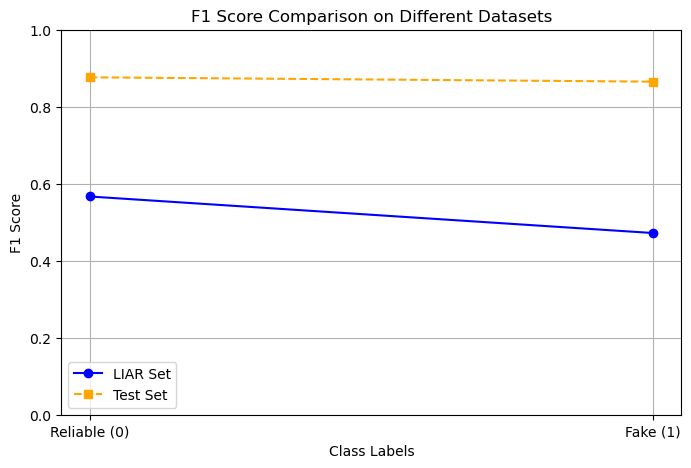

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Class Labels
classes = ["Reliable (0)", "Fake (1)"]

# Confusion Matrices
cm_A = np.array([[246, 203], [173, 168]])  # LIAR Set
cm_B = np.array([[34291, 5132], [4541, 31023]])  # Test Set

# Function to calculate Precision, Recall, and F1 Score for each class
def calculate_f1_score(cm):
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Reliable (0)
    recall_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0])   # Reliable (0)
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)  # F1 for Reliable (0)
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # Fake (1)
    recall_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1])   # Fake (1)
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)  # F1 for Fake (1)
    
    return [f1_0, f1_1]

# Calculate F1 scores for both datasets
f1_A = calculate_f1_score(cm_A)
f1_B = calculate_f1_score(cm_B)

# Plot the comparison
plt.figure(figsize=(8, 5))
plt.plot(classes, f1_A, marker='o', linestyle='-', color='blue', label="LIAR Set")
plt.plot(classes, f1_B, marker='s', linestyle='--', color='orange', label="Test Set")

# Labels and Titles
plt.xlabel("Class Labels")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison on Different Datasets")
plt.ylim(0, 1)  # F1 Score ranges from 0 to 1
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


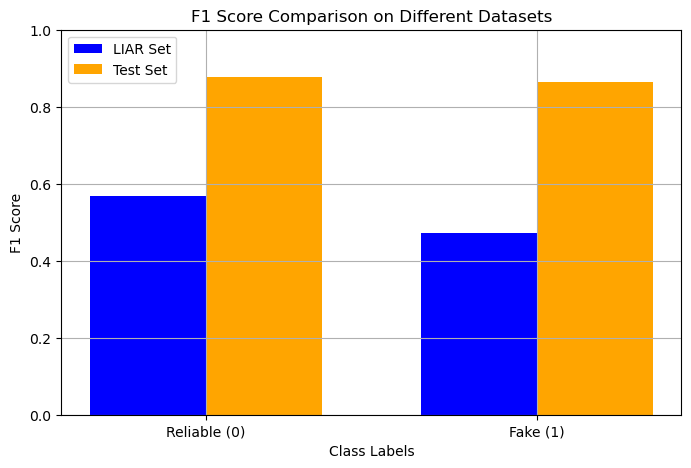

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Class Labels
classes = ["Reliable (0)", "Fake (1)"]

# Confusion Matrices
cm_A = np.array([[246, 203], [173, 168]])  # LIAR Set
cm_B = np.array([[34291, 5132], [4541, 31023]])  # Test Set

# Function to calculate Precision, Recall, and F1 Score for each class
def calculate_f1_score(cm):
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Reliable (0)
    recall_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0])   # Reliable (0)
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)  # F1 for Reliable (0)
    
    precision_1 = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # Fake (1)
    recall_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1])   # Fake (1)
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)  # F1 for Fake (1)
    
    return [f1_0, f1_1]

# Calculate F1 scores for both datasets
f1_A = calculate_f1_score(cm_A)
f1_B = calculate_f1_score(cm_B)

# Plot the comparison as a bar chart
bar_width = 0.35  # Width of the bars
x = np.arange(len(classes))  # X positions for each class

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, f1_A, bar_width, label="LIAR Set", color='blue')
plt.bar(x + bar_width/2, f1_B, bar_width, label="Test Set", color='orange')

# Labels and Titles
plt.xlabel("Class Labels")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison on Different Datasets")
plt.xticks(x, classes)  # Set class labels on X-axis
plt.ylim(0, 1)  # F1 Score ranges from 0 to 1
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
